# ARTIDIS MedicalNewsToday assignment

## Data import

Let's start with importing the dataset and a quick overview of the samples.

In [1]:
import os

base_path = './articles'

articles = []
for file_name in  os.listdir(base_path):
    with open(os.path.join(base_path, file_name), 'r') as f:
        articles.append(f.read())

In [2]:
articles[:5]

['Two US cancer nurses have researched the evidence behind a commonly applied rule that cancer patients should not apply skin creams or lotions for four hours before having radiotherapy treatment and found there is little evidence to support this belief and that practice varies widely. Trish Bieck and Shannon Phillips from the James P. Wilmot Cancer Center, University of Rochester Medical Center, New York, wrote about their research in the journal Clinical Journal of Oncology Nursing; their paper appeared in the January online issue. Although it might seem like a minor matter compared to the complexity of cancer treatment, skin care is important to radiotherapy patients because the procedure can lead to excessive skin dryness and damage that can lead to infection. Bieck, who prompted and led the research, has worked in radiation oncology for 20 years. She noticed how skin issues were a constant source of anxiety for patients receiving radiotherapy and began to wonder about how much myt

Every article is a single string in the list.

Hence, first step for further data analisis and visualisation is the tokenisation step:

In [3]:
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.tokenizer

tokenized_articles = []
for article in articles:
    tokenized_articles.append(tokenizer(article))

Print a few tokens of a single article:

In [4]:
for i, token in enumerate(tokenized_articles[-1]):
    print(token.text)
    if i == 13:
        break

CoolSculpting
and
liposuction
are
both
surgical
methods
for
removing
body
fat
.
CoolSculpting
is


We see that punctuations are included as tokens. We might want to remove those at a later step. For now, this is okay though.

Let's have a look at the article length histogram:

Article Length: Median: 1168.0, mean: 1339.377, std: 1119.527


Text(0.5, 1.0, 'Article Length Distribution')

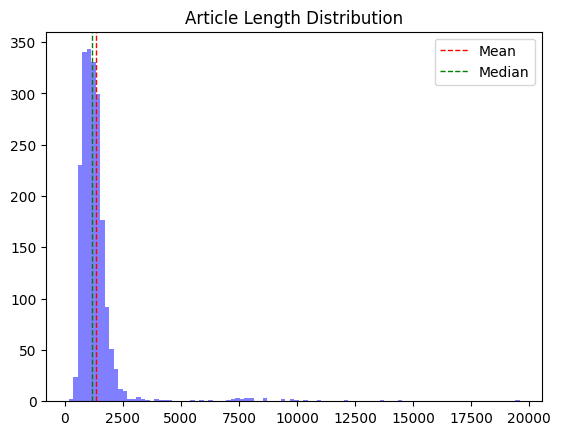

In [5]:
import matplotlib.pyplot as plt
import numpy as np

article_lengts = [len(article) for article in tokenized_articles]
artc_len_std = np.std(article_lengts)
artc_len_mean = np.mean(article_lengts)
artc_len_median = np.median(article_lengts)
print(f'Article Length: '
      f'Median: {artc_len_median}, '
      f'mean: {artc_len_mean:.3f}, '
      f'std: {artc_len_std:.3f}')

plt.hist(article_lengts, bins=100, color='b', alpha=0.5)
# plot mean and median
plt.axvline(artc_len_mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(artc_len_median, color='g', linestyle='dashed', linewidth=1)
plt.legend({'Mean': artc_len_mean, 'Median': artc_len_median})
plt.title('Article Length Distribution')

The sentence lengths might be useful as well:

In [6]:
sentence_lengts = []
for article in tokenized_articles:
    length = 0
    for token in article:
        if token.text == '.':
            sentence_lengts.append(length)
            length = 0
        else:
            length += 1
sentence_lengts[:5]

[45, 43, 39, 17, 60]

Sentence Length: Median: 17.0, Mean: 18.957, Std: 11.383


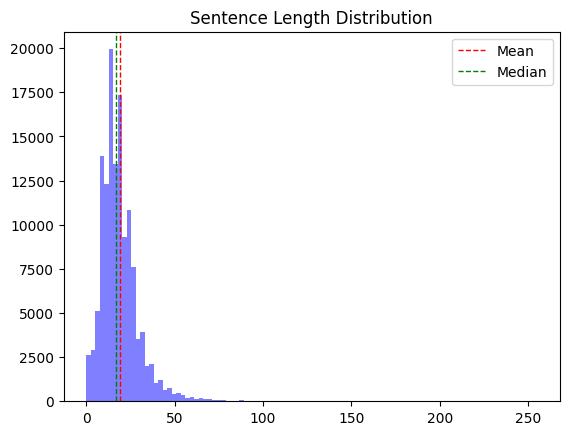

In [7]:
sent_len_mean = np.mean(sentence_lengts)
sent_len_median = np.median(sentence_lengts)
sent_len_std = np.std(sentence_lengts)
print(f'Sentence Length: '
      f'Median: {sent_len_median}, '
      f'Mean: {sent_len_mean:.3f}, '
      f'Std: {sent_len_std:.3f}')

plt.hist(sentence_lengts, bins=100, color='b', alpha=0.5)
# plot mean and median
plt.axvline(sent_len_mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(sent_len_median, color='g', linestyle='dashed', linewidth=1)
plt.legend({'Mean': sent_len_mean, 'Median': sent_len_median})
plt.title('Sentence Length Distribution');

### Clean the corpus from stopwords and lemmatize

In [8]:
import spacy
import tqdm

def preprocess_documents(documents: list[str]) -> list[str]:
    nlp = spacy.load('en_core_web_sm',
                     disable=['parser', 'ner'])

    preprocessed_documents = []

    for document in tqdm.tqdm(documents):
        # Tokenize the document
        doc = nlp(document)
        # Lemmatize and remove stop words + punctuation
        lemmatized_words = [token.lemma_ for token in doc
                            if (not token.is_stop and not token.is_punct)]
        preprocessed_documents.append(lemmatized_words)

    return preprocessed_documents

preprocessed_articles = preprocess_documents(articles)

100%|██████████| 1989/1989 [02:40<00:00, 12.37it/s]


In [9]:
preprocessed_articles[0][:10]

['cancer',
 'nurse',
 'research',
 'evidence',
 'commonly',
 'apply',
 'rule',
 'cancer',
 'patient',
 'apply']

In [10]:
# extract the vocabulary for further analysis

from collections import Counter

vocab = Counter()
for article in preprocessed_articles:
    for token in article:
        vocab[token] += 1

print("Vocabulary size: ", len(vocab))
vocab.most_common(10)

Vocabulary size:  32256


[('people', 12153),
 ('person', 11553),
 ('cause', 10551),
 ('doctor', 10504),
 ('symptom', 10458),
 ('include', 9181),
 ('treatment', 8299),
 ('help', 7560),
 ('condition', 6562),
 ('study', 6401)]

In [11]:
vocab_list = list(vocab.keys())

## Create word vector representations and visualise medical term vectors

To gather some understanding on the medical terms used in the articles, we're creating word vectors using the n-gram model and PCA:

In [12]:
def get_coocurrance_matrix(articles: list[list[str]],
                           vocab: list[str],
                           n_gram_count: int = 3) -> np.ndarray:
    """Calculate a coocurrance matrix of size (len(vocab), len(vocab)).
    
    TODO (optional): Implement this function using sparse matrices.
    Make this much more efficient in general.

    Parameters
    ----------
    articles : list
        A list of articles, where each article is a list of tokens.
    vocab : list
        A list of tokens to consider for coocurrance.
    n_gram_count : int
        The number of tokens to consider for coocurrance.
    
    Returns
    -------
    np.ndarray
        A coocurrance matrix of size (len(vocab), len(vocab)).

    """
    coocurrance_matrix = np.zeros((len(vocab), len(vocab)))
    for article in tqdm.tqdm(articles):
        for i in range(len(article) - n_gram_count):
            for j in range(i + 1, i + n_gram_count):
                if article[i] in vocab and article[j] in vocab:
                    coocurrance_matrix[vocab.index(article[i]),
                                       vocab.index(article[j])] += 1
    return coocurrance_matrix

coocurrance_matrix = get_coocurrance_matrix(preprocessed_articles,
                                            vocab_list,
                                            n_gram_count = 3)

100%|██████████| 1989/1989 [03:01<00:00, 10.96it/s]


In [13]:
coocurrance_matrix.shape

(32256, 32256)

Use PCA to create word embeddings:

In [14]:
from sklearn.decomposition import PCA

n_dims = 100
pca = PCA(n_components=n_dims)
word_embeddings = pca.fit_transform(coocurrance_matrix)

In [15]:
word_embeddings.shape

(32256, 100)

Let's observe some similarities:

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

def find_n_most_similar_vectors(vector, vectors, n):
    # repeat vector to match shape of vectors
    # vector = np.tile(vector, (vectors.shape[0], 1))
    vector = vector.reshape(1, -1)
    similarities = cosine_similarity(vector, vectors).squeeze()
    top_n_idx = similarities.argsort()[-(n+1):][::-1]
    return similarities[top_n_idx][1:], top_n_idx[1:]

center = word_embeddings[vocab_list.index('headache')]
values, idx = find_n_most_similar_vectors(center, word_embeddings, 10)

print('Most similar words to "headache":')
for i, sim in zip(idx, values):
    print(round(sim, 4), vocab_list[i])

Most similar words to "headache":
0.9123 cramp
0.8971 fever
0.8812 vomiting
0.8755 abdoman
0.8723 breath
0.8492 migraine
0.8477 bloat
0.8433 diarrhea
0.8342 fatigue
0.8337 constipation


## Create embeddings for the documents and cluster

In [17]:
document_embeddings = []

for article in preprocessed_articles:
    embedding = np.zeros((n_dims,), dtype=np.float32)
    for token in article:
        embedding += word_embeddings[vocab_list.index(token)]
    document_embeddings.append(embedding / np.linalg.norm(embedding))

document_embeddings = np.array(document_embeddings)

In [18]:
document_embeddings.shape

(1989, 100)

Dimensionality reduction with t-SNE

In [19]:
from sklearn.manifold import TSNE

docs_reduced = TSNE(n_components=2,
                    learning_rate='auto',
                    init='random',
                    perplexity=3).fit_transform(document_embeddings)
docs_reduced.shape

(1989, 2)

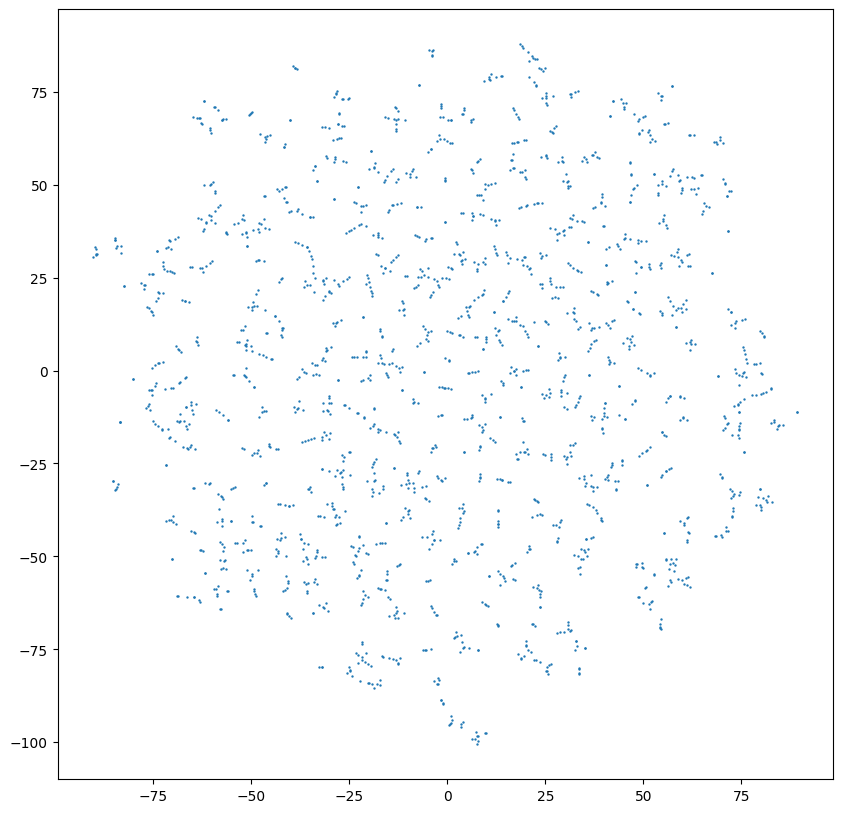

In [20]:
# plot doc_embeddings
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(docs_reduced[:, 0], docs_reduced[:, 1], s=0.5);

We observe some very scattered clusters. This might be due to the fact that all documents share the same domain, i.e. contain medical data. However, some local clusters might indicate articles with similar content. Hence, we can try to query similar articles from an given example using the K-nearest neighbours; Let's have a look at a random example:

In [73]:
import random

random.seed(0)

r = random.randint(0, len(articles))
random_article = articles[r]
print(random_article)

If you buy something through a link on this page, we may earn a small commission. How this works. There are several causes of headaches behind the ear. With proper medical treatment, these headaches can be relieved. A headache behind the ear refers to any pain that originates from that specific area of the head. Though headaches themselves are very common, headaches that occur exclusively behind the ear are fairly unusual. This type of headache pain can have several causes from nerve injury to dental problems. The cause of the headache behind the ear will determine symptoms and treatment. This article explores the signs and symptoms of headaches behind the ear and details what causes them. It also discusses how they can be treated to relieve pain and the associated symptoms. There are several possible causes of a headache behind the ear. These include the following:One of the most common causes of a headache behind the ear is a condition called occipital neuralgia. Occipital neuralgia 

The article is about headaches behind the ear. Let's test our document embeddings by quering the three closest articles:

In [75]:
def get_k_nearest_neighbours(vector, vectors, n):
    # repeat vector to match shape of vectors
    vector = np.tile(vector, (vectors.shape[0], 1))
    diff = np.sum((vectors - vector) ** 2, axis=1)
    top_n_idx = diff.argsort()[:(n+1)]
    return diff[top_n_idx][1:], top_n_idx[1:]


sims, idxs = get_k_nearest_neighbours(docs_reduced[r], docs_reduced, 5)

for sim, idx in zip(sims, idxs):
    print(f"Similarity: {sim:.4f}")
    print(f"Text: {articles[idx]}")
    print()

Similarity: 0.2089
Text: Occasionally, people have a buzzing, tingling, or vibrating sensation in or around the vagina. The feeling may come and go, and it can range in intensity. It may be a mild irritation or a painful spasm. Each person may have a different experience. In most cases, this vibrating sensation is not a cause for concern. Feeling a slight, unexpected vibration in the vagina can be a normal experience, and there are several benign causes. Keep reading for more information about what causes a vibrating vagina and what to do about it. The cause of this feeling is not always clear. For many people, the sensation comes and goes sporadically. As a result, a person may hesitate to report it to a doctor or discuss it with others. This may partly explain why there is a lack of research into this vaginal sensation. Nonetheless, some potential causes of vibrating in or around the vagina are:The pelvic floor is a layer of muscles and ligaments that connect the pelvic bone to the b

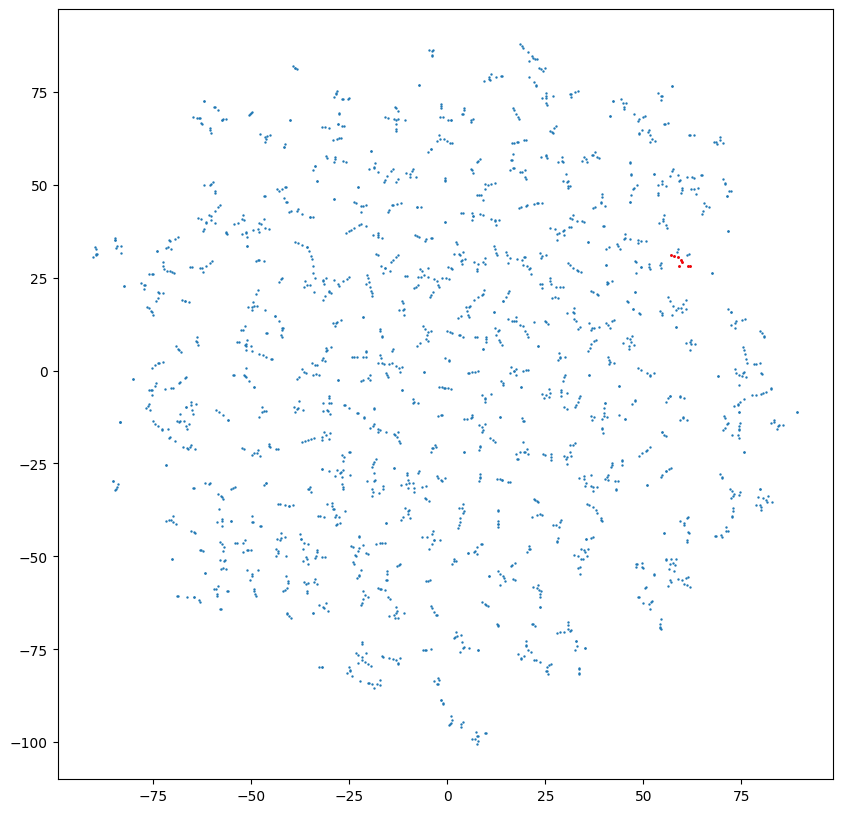

In [72]:
# Let's visualize where the data lays in the space

mark_red = np.append(idxs, r)
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(docs_reduced[:, 0], docs_reduced[:, 1], s=0.5)
ax.scatter(docs_reduced[mark_red, 0], docs_reduced[mark_red, 1], s=1, c='r');

## Conclusion

We see that the general sense in all plotted atricles circles around pain sensations. This matches with the 10 similar words for 'headache' previously. However, ideally we would like to retrieve documents that share information about headaches. Another method that we could use for document retrieval is the td-idf method.